In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

%matplotlib inline

now = datetime.datetime.now

# 增加批量大小
batch_size = 32
# 数据序列的长度
n_timesteps = 240
# 数据序列的维度
n_dim = 117

# 假设 DataViconLoad 模块中有一个函数 load_data 用于加载数据
import DataViconLoad
X_correct, X_incorrect = DataViconLoad.load_data()

# 数据预处理
data_correct = np.zeros((X_correct.shape[0], n_timesteps + 100, n_dim))
for i in range(X_correct.shape[0]):
    data_correct[i, :, :] = np.concatenate((
        np.tile(X_correct[i, 0, :], (50, 1)),
        X_correct[i, :, :],
        np.tile(X_correct[i, -1, :], (50, 1))
    ))

data_incorrect = np.zeros((X_incorrect.shape[0], n_timesteps + 100, n_dim))
for i in range(X_incorrect.shape[0]):
    data_incorrect[i, :, :] = np.concatenate((
        np.tile(X_incorrect[i, 0, :], (50, 1)),
        X_incorrect[i, :, :],
        np.tile(X_incorrect[i, -1, :], (50, 1))
    ))

# 模型架构定义
input_seq = Input(shape=(n_timesteps + 100, n_dim))
encoded1 = LSTM(30, return_sequences=True)(input_seq)
encoded2 = LSTM(10, return_sequences=True)(encoded1)
encoded = LSTM(4, return_sequences=True)(encoded2)
decoded1 = LSTM(10, return_sequences=True)(encoded)
decoded2 = LSTM(30, return_sequences=True)(decoded1)
decoded = LSTM(n_dim, return_sequences=True)(decoded2)

# 构建和编译自动编码器模型
autoencoder = Model(inputs=input_seq, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# 数据分割
import random
trainidx = random.sample(range(0, data_correct.shape[0]), 63)
valididx = np.setdiff1d(np.arange(0, 90, 1), trainidx)
train_data = data_correct[trainidx, :, :]
valid_data = data_correct[valididx, :, :]

# 训练自动编码器
t = now()

# 提前停止
early_stopping = EarlyStopping(monitor='val_loss', patience=1000)

# 使用 tf.data API 加载数据，提高性能
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size).shuffle(buffer_size=1024).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_data)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

history = autoencoder.fit(train_dataset, epochs=10000, validation_data=valid_dataset, verbose=0, callbacks=[early_stopping])

print('Training time: %s' % (now() - t))


2024-07-29 13:08:29.804625: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 13:08:29.822584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 13:08:29.842346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 13:08:29.848220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 13:08:29.864062: I tensorflow/core/platform/cpu_feature_guar

Shape of data_correct5: (90, 240, 117)
Shape of data_incorrect5: (90, 240, 117)


2024-07-29 13:08:37.303836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:16:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 340, 117)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 340, 30)        │        17,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 340, 10)        │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 340, 4)         │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 340, 10)        │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 340, 30)        │         4,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 340, 117)       │        69,264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,424 (368.84 KB)

 Trainable params: 94,424 (368.84 KB)

 Non-trainable params: 0 (0.00 B)

2024-07-29 13:08:41.399819: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


Training time: 0:22:11.206382


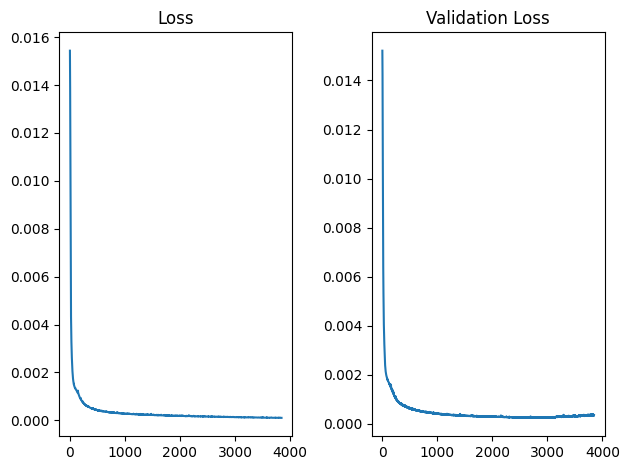

0.00010316946281818673
0.0003621209762059152


In [2]:
# Plot the training and validation results
plt.figure(1)
plt.subplot(121)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.tight_layout()
plt.show()

# Print the resulting training and validation loss values
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


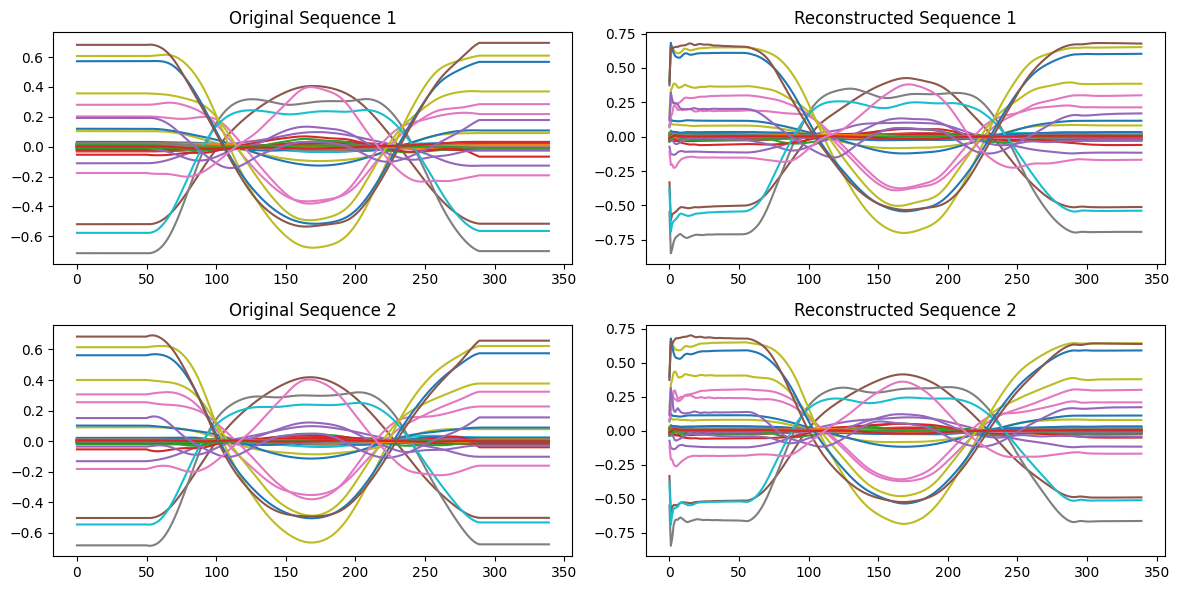

In [3]:
# Encode and decode sequences to check the model performance
decoded_seqs = autoencoder.predict(data_correct)
# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])
    plt.title(f"Original Sequence {i+1}")
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(decoded_seqs[i])
    plt.title(f"Reconstructed Sequence {i+1}")
plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


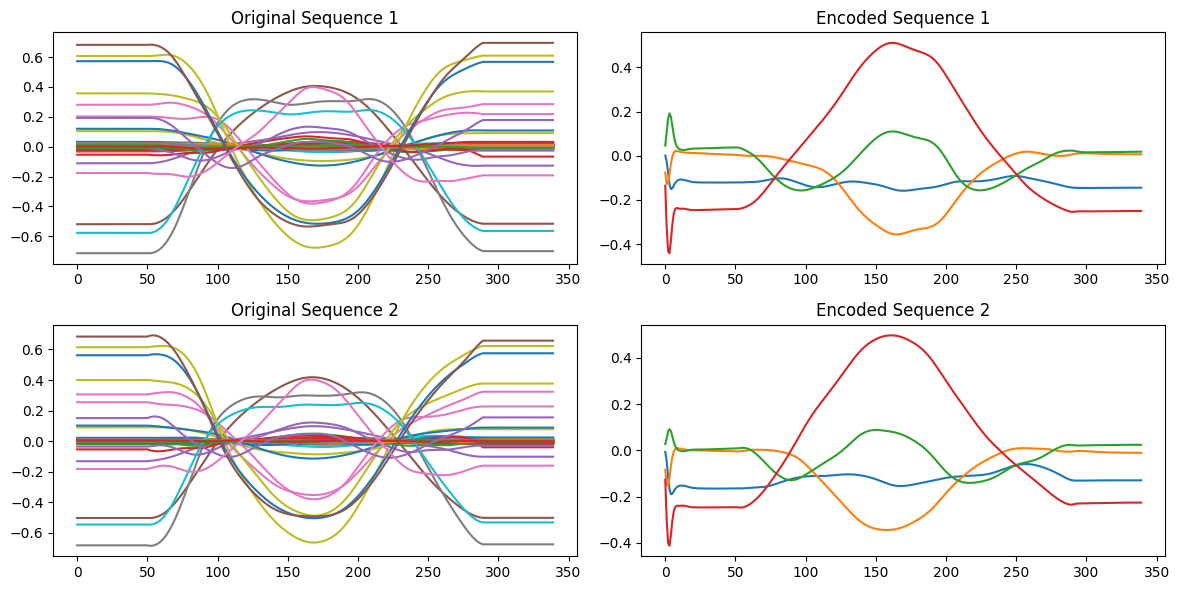

In [4]:
# Create an encoder model, that maps an input to its encoded representation
encoder = Model(inputs=input_seq, outputs=encoded)

# Test the encoder model
encoded_seqs = encoder.predict(data_correct)

# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])
    plt.title(f"Original Sequence {i+1}")
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(encoded_seqs[i])
    plt.title(f"Encoded Sequence {i+1}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1849/1442812958.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,1,1)
/tmp/ipykernel_1849/1442812958.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,1,2)
/tmp/ipykernel_1849/1442812958.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created an

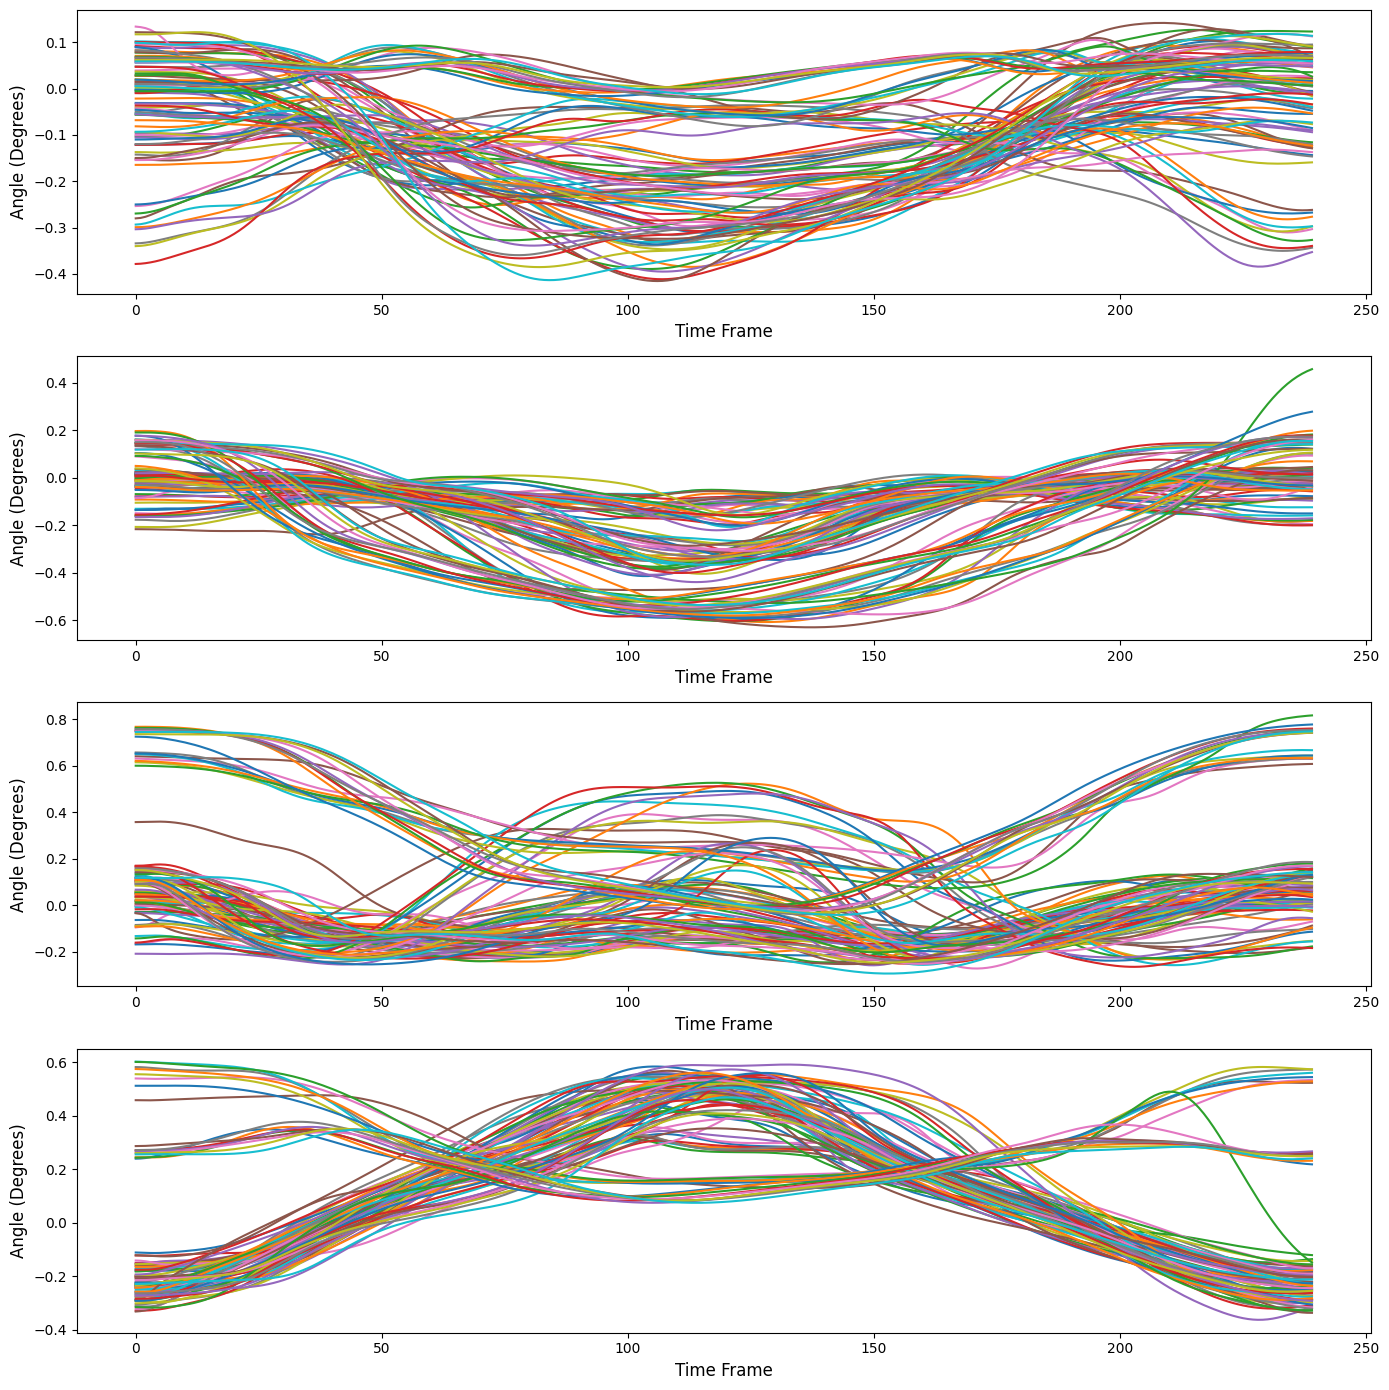

In [5]:
# Plot all encoded sequences without the first and last 50 time frames
plt.figure(figsize = (14,14))
for i in range(data_correct.shape[0]):
    plt.subplot(4,1,1)
    plt.plot(encoded_seqs[i,50:-50,0])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,2)
    plt.plot(encoded_seqs[i,50:-50,1])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,3)
    plt.plot(encoded_seqs[i,50:-50,2])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,4)
    plt.plot(encoded_seqs[i,50:-50,3])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
# Remove the added first and last 50 frames 
encoded_seqs = encoded_seqs[:,50:-50,:]

print(encoded_seqs.shape, 'encoded sequences shape')
# Reshape the encoded sequences, because savetxt saves two dimensional data
seqs = encoded_seqs.reshape(encoded_seqs.shape[0],encoded_seqs.shape[1]*encoded_seqs.shape[2])
print(seqs.shape, 'encoded sequences shape for saving')
# Save the data in the file 'Autoencoder_Output_Correct.csv'
np.savetxt('/root/autodl-tmp/data/m07/Autoencoder_Output_Correct_m07.csv', seqs, fmt='%.5f',delimiter=',')

(90, 240, 4) encoded sequences shape
(90, 960) encoded sequences shape for saving


In [7]:
encoded_seqs_incorrect = encoder.predict(data_incorrect)
# Remove the added first and last 50 frames 
encoded_seqs_incorrect = encoded_seqs_incorrect[:,50:-50,:]

print(encoded_seqs_incorrect.shape, 'encoded incorrect sequences shape')
# Reshape the encoded sequences, because savetxt saves only tow dimensional data
seqs_incorrect = encoded_seqs_incorrect.reshape(encoded_seqs_incorrect.shape[0],encoded_seqs_incorrect.shape[1]*encoded_seqs_incorrect.shape[2])
print(seqs_incorrect.shape, 'encoded incorrect sequences shape for saving')
# Save the incorrect data in the file 'Autoencoder_Output_Incorrect.csv'
np.savetxt('/root/autodl-tmp/data/m07/Autoencoder_Output_Incorrect_m07.csv', seqs_incorrect, fmt='%.5f',delimiter=',')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(90, 240, 4) encoded incorrect sequences shape
(90, 960) encoded incorrect sequences shape for saving


: 